<a href="https://colab.research.google.com/github/pleabargain/ipynb_notebooks/blob/master/rhyme_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

from https://github.com/adampalay
updated code with sort_index

# Rhyme Distributions in Shakespeare's Sonnets
In this notebook, we'll analyze the rhyme distributions in Shakespeare's sonnets.
We'll start by extracting the sonnets from a Project Gutenberg webpage, then use [nltk](http://www.nltk.org/) to analyze the sonnets' rhymes. We'll also use [pandas](http://pandas.pydata.org/) to make some simple bar graphs (because who really has the time to work through the matplotlib api?).

This is supplementary material to my talk [Words, Words, Words: Reading Shakespeare with Python](/pycon2015)

Download this notebook [here](/notebooks/rhyme-distributions.ipynb)

In [0]:
import requests
from lxml import etree
import nltk
import string
import pandas as pd
# include this line to generate graphs in the body of the notebook
%matplotlib inline

## Setup

### Get sonnets from project gutenberg:

In [0]:
def pull_sonnets():
    sonnets_html = requests.get('http://www.gutenberg.org/files/1041/1041-h/1041-h.htm').content
    html = etree.HTML(sonnets_html)
    poems_elements = [element for element in html.xpath("//p[@class='poem']")]
    clean_sonnets = []
    for element in poems_elements:
        clean_sonnet = "\n".join([text.strip() for text in element.itertext() if text.strip()])
        clean_sonnets.append(clean_sonnet)
    return clean_sonnets

In [0]:
sonnets = pull_sonnets()

### Clean text and extract rhymes from sonnets

In [0]:
def last_word(line):
    """
    Takes a line and returns the last work in the line
    """
    # split the line into words
    words = line.split()
    # take the last word
    last = words[-1]
    # remove leading/trailing punctuation
    # and make lowercase
    last = last.strip(string.punctuation).lower()
    return last

In [0]:
def get_rhymes(sonnets):
    rhymes = []
    for sonnet in sonnets:
        lines = sonnet.split('\n')
        if len(lines) != 14:
            continue
        # since we know sonnets have the same rhyme scheme
        # (abab cdcd efef gg) we can "hard code" it here
        for index in xrange(12):
            if index % 4 in [0, 1]:
                pair = (last_word(lines[index]), last_word(lines[index + 2]))
                rhymes.append(pair)
        rhymes.append((last_word(lines[12]), last_word(lines[13])))
    return rhymes


## Rhyme Distributions:

### Frequency Distribution
Here we're going to use nltk's `FreqDist` class to create a frequency distributions of the rhymes in the sonnets. So, at the end, we'll get a mapping of each rhyme to the amount of times it occurs. 

In [0]:
rhymes = get_rhymes(sonnets)
fd = nltk.FreqDist(rhymes)

In [7]:
for rhyme, freq in fd.most_common(10):
    print rhyme, freq

(u'thee', u'me') 14
(u'me', u'thee') 9
(u'thee', u'be') 8
(u'days', u'praise') 6
(u'heart', u'art') 5
(u'heart', u'part') 5
(u'love', u'prove') 5
(u'prove', u'love') 4
(u'face', u'disgrace') 4
(u'eyes', u'lies') 4


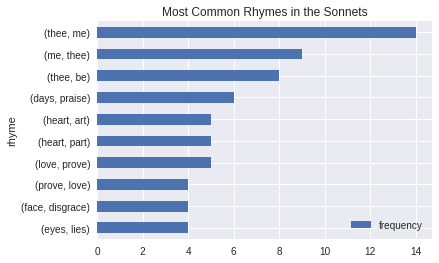

In [10]:
df = pd.DataFrame(fd.most_common(10))
df.columns = ["rhyme", "frequency"]
df.sort_index(ascending=False).plot(
    kind='barh',
    x='rhyme',
    title="Most Common Rhymes in the Sonnets",
)

### Conditional Frequency Distribution
Here we're going to build something a little more nuanced. Here, we want to know this: for a given word, what is the frequency distribution of the words that rhyme with it.

To answer that question, we use a `ConditionalFreqDist`:

In [11]:
rhymes = rhymes + [tuple(reversed(rhyme)) for rhyme in rhymes]
cfd = nltk.ConditionalFreqDist(rhymes)
for word, freq in cfd["thee"].most_common():
    print word, freq

me 23
be 12
see 5
thee 2
melancholy 1
free 1
posterity 1
usury 1


In [12]:
# note that cfd["thee"] is itself a frequency distribution:
type(cfd['thee'])

nltk.probability.FreqDist

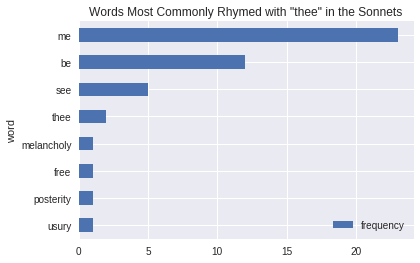

In [14]:
# plot this distribution using pandas
df2 = pd.DataFrame(cfd['thee'].most_common(), columns=['word', 'frequency'])
df2.sort_index(ascending=False).plot(
    kind='barh', x='word', title='Words Most Commonly Rhymed with "thee" in the Sonnets'
)